In [10]:
import os

import numpy as np
import matplotlib.pyplot as plt

In [58]:
# Read data from binary file DAT
class DTA():
    '''
    The data file class
    '''
    def __init__(self, filename):
        self.dat_filename = filename
        self.dsc_filename = os.path.splitext(filename)[0] + '.DSC'
        self.dsc_ascii_filename = os.path.splitext(filename)[0] + '_dsc.txt'
        
        self.data = None
        self.x_axis = None
        self.y_axis = None
        self.csv_header = None
        
        self.parameters = self.read_dsc(self.dsc_filename) 
        self.dtype = self.get_dtype()
        
    '''
    Read DSC file and load to parameters attribute
    '''
    def read_dsc(self, filename):
        parameters = dict()
        with open(filename) as fp:
            lines = fp.readlines()
            for line in lines:
                if line[0] in ['*', '#', '\n', '\t', '.', ' ']:
                    continue
                parameter_lst = line.split()
                parameters[parameter_lst[0]] = ' '.join(parameter_lst[1:])
        return parameters
    
    '''
    Export parameters as ASCII file
    '''
    def dsc_export_ASCII(self, filename=None):
        if filename is None:
            filename = os.path.splitext(self.dat_filename)[0] + '_dsc.txt'
        with open(filename, 'w') as fp:
            lines = [(f'{key}\t{val}\n') for key, val in self.parameters.items()]
            fp.writelines(lines)
            
    '''
    Get data type from parameters and load it to dtype variable
    '''
    def get_dtype(self):
        IRFMT_REAL_dict = {'C': 'b', 'S': 'h', 'I': 'I', 'F': 'f', 'D': 'd'}
        IRFMT_CPLX_dict = {'F': 'F', 'D': 'D'}
        BSEQ_dict = {'BIG': '>', 'LIT': '<'}
        
        if self.parameters['IKKF'] == 'CPLX':
            return BSEQ_dict[self.parameters['BSEQ']] +\
                    IRFMT_CPLX_dict[self.parameters['IRFMT']]
        elif self.parameters['IKKF'] == 'REAL':
            return BSEQ_dict[self.parameters['BSEQ']] +\
                    IRFMT_REAL_dict[self.parameters['IRFMT']]
        
    '''
    Load data
    '''
    def load_data(self):
        if self.parameters['YTYP'] == 'NODATA':
            self.load_1D()
        else:
            self.load_2D()
        
    '''
    Constuct csv header
    '''
    def get_csv_header(self, sep='\t'):
        try:
            xnam = self.parameters['XNAM']
        except Exception:
            print("'XNAM' not found in the DSC file")
            xnam = ''
        self.csv_header = ['{} ({})'.format(xnam.replace("\'", ''), self.parameters['XUNI'].replace("\'", '')),
                          '{} ({})\n'.format(self.parameters['IRNAM'].replace("\'", ''), self.parameters['IRUNI'].replace("\'", '')) 
                          ]
        self.csv_header = sep.join(self.csv_header)
        
    '''
    Load 1D data to data attribute
    '''
    def load_1D(self):
        data = np.fromfile(
            self.dat_filename, 
            dtype=self.dtype,
            count=-1,
            sep='',
            offset=0,
        )
        
        xmin = np.double(self.parameters['XMIN'])
        xwid = np.double(self.parameters['XWID'])
        xpts = int(self.parameters['XPTS'])
        x_axis = np.linspace(xmin, xmin + xwid, xpts)
        
        self.data = ((x_axis, ), data)
        
    '''
    Load 2D data to data attribute 
    '''
    def load_2D(self):
        
        xmin = np.double(self.parameters['XMIN'])
        xwid = np.double(self.parameters['XWID'])
        xpts = int(self.parameters['XPTS'])
        x_axis = np.linspace(xmin, xmin + xwid, xpts)
        
        ypts = int(self.parameters['YPTS'])
        ymin = np.double(self.parameters['YMIN'])
        ywid = np.double(self.parameters['YWID'])
        if self.parameters['YTYP'] == 'IDY':
            y_axis = np.linspace(ymin, ymin + ywid, ypts)
        elif self.parameters['YTYP'] == 'IGD':
            y_axis = self.load_YGF()
        else:
            # unknown y-axis values
            pass
            
        data = np.fromfile(
            self.dat_filename, 
            dtype=self.dtype,
            count=-1,
            sep='',
            offset=0,
        )
        data = data.reshape(ypts, xpts).T
        
        self.data = ((x_axis, y_axis), data)
        
    '''
    Load y-axis scan from ygf file and load it to y_axis attribute
    '''
    def load_YGF(self):
        filename = os.path.splitext(self.dat_filename)[0] + '.YGF'
        y_axis = np.fromfile(
            filename,
            dtype=self.dtype,
            count=-1,
            sep='',
            offset=0,
        )   
        return y_axis
    
    '''
    Export data to ASCII file
    '''
    def data_export_ASCII(self, filename=None, sep='\t', fmt='%.6f'):
        if filename is None:
            filename = os.path.splitext(self.dat_filename)[0] + '.dat'
        data_to_save = np.column_stack(self.data)
        with open(filename, 'w') as fp:
            np.savetxt(fp, data_to_save, delimiter=sep, fmt=fmt)
            
    '''
    Export data to csv file
    '''
    def export_csv(self, filename=None, sep=',', fmt='%.6f', header=True ):
        if filename is None:
            filename = os.path.splitext(self.dat_filename)[0] + '.csv'
        data_to_save = np.column_stack(self.data)
        with open(filename, 'w') as fp:
            if header:
                fp.write(self.get_csv_header(sep=sep))
            np.savetxt(fp, data_to_save, delimiter=sep, fmt=fmt)

In [59]:
# Testing 
dta = DTA('./data/2D/80K_redplane_CW_15dB.DTA')
dta.load_data()

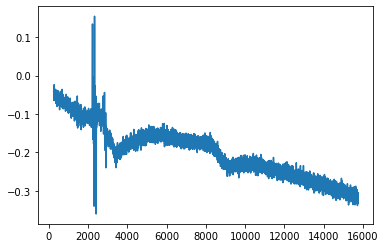

In [69]:
plt.plot(dta.data[0][0], dta.data[1][:, 5]);

In [12]:
dsc = DSC('./data/en5107d2_echodecay1.DSC')
dsc.read_dsc()

dta = DTA('./data/en5107d2_echodecay1.DTA', dsc.parameters)
dta.load_data()

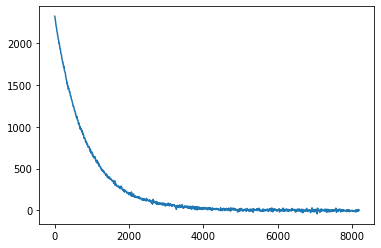

In [18]:
plt.plot(dat.data[0], np.real(dat.data[1]));